1. Data Loading and Preprocessing

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
file_path = r'C:\Users\DELL\Downloads\default_of_credit_card_clients.xlsx'  # Update with your file path
df = pd.read_excel(file_path)

# Clean the data: Remove unnecessary headers and convert columns to numeric types
df_cleaned = df.drop(index=0).rename(columns={'default payment next month': 'Y'}).drop(columns=['Unnamed: 0'])
X = df_cleaned.drop(columns=['Y'])
y = df_cleaned['Y'].astype(int)

# Convert all columns to numeric
X_cleaned = X.apply(pd.to_numeric, errors='coerce')

# Check for missing values and fill them with the mean
X_imputed = X_cleaned.fillna(X_cleaned.mean())

# Print first few rows of the imputed data to verify the result
print(X_imputed.head())


       X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  ...    X14    X15    X16  \
1   20000   2   2   1  24   2   2  -1  -1   -2  ...    689      0      0   
2  120000   2   2   2  26  -1   2   0   0    0  ...   2682   3272   3455   
3   90000   2   2   2  34   0   0   0   0    0  ...  13559  14331  14948   
4   50000   2   2   1  37   0   0   0   0    0  ...  49291  28314  28959   
5   50000   1   2   1  57  -1   0  -1   0    0  ...  35835  20940  19146   

     X17   X18    X19    X20   X21   X22   X23  
1      0     0    689      0     0     0     0  
2   3261     0   1000   1000  1000     0  2000  
3  15549  1518   1500   1000  1000  1000  5000  
4  29547  2000   2019   1200  1100  1069  1000  
5  19131  2000  36681  10000  9000   689   679  

[5 rows x 23 columns]


2. Feature Engineering

In [2]:
# List of skewed columns to be transformed
skewed_columns = ['X19', 'X20', 'X18', 'X21', 'X22', 'X23', 'X14', 'X16', 'X17', 'X15', 'X13', 'X12', 'X10']

# Replace zero values with a small positive value and log-transform the data
X_imputed[skewed_columns] = X_imputed[skewed_columns].replace(0, 1e-6)

# Check for negative values and shift if necessary
for col in skewed_columns:
    min_value = X_imputed[col].min()
    if min_value < 0:
        print(f"Column {col} contains negative values. Shifting by {-min_value + 1e-6}.")
        X_imputed[col] += (-min_value + 1e-6)  # Shift the column to make all values positive
    X_imputed[col] = np.log1p(X_imputed[col])

# Print transformed data to verify
print(X_imputed[skewed_columns].head())


Column X14 contains negative values. Shifting by 157264.000001.
Column X16 contains negative values. Shifting by 81334.000001.
Column X17 contains negative values. Shifting by 339603.000001.
Column X15 contains negative values. Shifting by 170000.000001.
Column X13 contains negative values. Shifting by 69777.000001.
Column X12 contains negative values. Shifting by 165580.000001.
Column X10 contains negative values. Shifting by 2.000001.
         X19           X20           X18           X21           X22  \
1   6.536692  9.999995e-07  9.999995e-07  9.999995e-07  9.999995e-07   
2   6.908755  6.908755e+00  9.999995e-07  6.908755e+00  9.999995e-07   
3   7.313887  6.908755e+00  7.325808e+00  6.908755e+00  6.908755e+00   
4   7.610853  7.090910e+00  7.601402e+00  7.003974e+00  6.975414e+00   
5  10.510041  9.210440e+00  7.601402e+00  9.105091e+00  6.536692e+00   

            X23        X14        X16        X17        X15        X13  \
1  9.999995e-07  11.970059  11.306332  12.735536  12

3. Feature Importance Selection Using Random Forest

In [3]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest to identify important features
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_imputed, y)

# Get feature importance and select the top 15 most important features
feature_importance = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Select top 15 features
top_features = feature_importance_df['Feature'].head(15).values
X_top_features = X[top_features]

# Print the top features
print(X_top_features.head())


   X6  X5    X12      X1    X13    X14    X17    X15   X18    X16    X19  \
1   2  24   3913   20000   3102    689      0      0     0      0    689   
2  -1  26   2682  120000   1725   2682   3261   3272     0   3455   1000   
3   0  34  29239   90000  14027  13559  15549  14331  1518  14948   1500   
4   0  37  46990   50000  48233  49291  29547  28314  2000  28959   2019   
5  -1  57   8617   50000   5670  35835  19131  20940  2000  19146  36681   

     X20   X23   X21   X22  
1      0     0     0     0  
2   1000  2000  1000     0  
3   1000  5000  1000  1000  
4   1200  1000  1100  1069  
5  10000   679  9000   689  


4. Train-Test Split and Scaling

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_top_features, y, test_size=0.2, random_state=42)

# Apply StandardScaler for scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print scaled training data to verify
print(X_train_scaled[:5])  # Print the first 5 rows of the scaled training data


[[ 0.01479575 -1.2446578   0.32966974 -0.67235902  0.40097887  0.45570705
   0.01169789  0.47944982 -0.12689188 -0.00836705 -0.03953698 -0.17356677
  -0.24524018 -0.22465419 -0.21600791]
 [ 0.01479575 -0.81152149 -0.29544512 -1.05776818 -0.27364945 -0.25413172
  -0.65389759 -0.27718187 -0.03891505 -0.29932295 -0.19425036 -0.2415957
  -0.29553162 -0.24078483 -0.30852284]
 [ 0.01479575  0.92102376 -0.40887943  0.0984593  -0.68969797 -0.66278784
  -0.47947335 -0.67137143 -0.33193699 -0.54868545 -0.2104753  -0.28824568
  -0.28510675  0.12267581  0.35348711]
 [ 0.01479575 -1.13637372  0.10778755 -0.82652269  0.06091521 -0.11873596
   0.00635045 -0.05267097 -0.21381508 -0.00876287 -0.16723626 -0.17861001
  -0.18097254 -0.20735823 -0.18687691]
 [ 0.01479575 -1.13637372  0.82643189 -0.28694986  0.89440816  0.98142318
   1.43622436  1.16765438 -0.09194699  1.33098333 -0.07252219 -0.01415651
   0.31735947  0.00730803  0.01159803]]


5. Handle Class Imbalance Using SMOTE

In [5]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


6. Fine-tune Random Forest

In [6]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters grid for Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Perform GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=3, n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train_resampled, y_train_resampled)
best_rf_model = rf_grid_search.best_estimator_

# Print the best Random Forest model
print(f"Best Random Forest Model: {best_rf_model}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Random Forest Model: RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)


7. Fine-tune Gradient Boosting

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the hyperparameters grid for Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Perform GridSearchCV for Gradient Boosting
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, cv=3, n_jobs=-1, verbose=1)
gb_grid_search.fit(X_train_resampled, y_train_resampled)
best_gb_model = gb_grid_search.best_estimator_

# Print the best Gradient Boosting model
print(f"Best Gradient Boosting Model: {best_gb_model}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Gradient Boosting Model: GradientBoostingClassifier(max_depth=7, n_estimators=200, random_state=42)


8. Create an Ensemble Model

In [8]:
from sklearn.ensemble import VotingClassifier

# Create the Voting Classifier (ensemble of Random Forest and Gradient Boosting)
ensemble_model = VotingClassifier(estimators=[
    ('rf', best_rf_model),
    ('gb', best_gb_model)
], voting='soft')

# Train the ensemble model
ensemble_model.fit(X_train_resampled, y_train_resampled)
print("Ensemble model training is complete.")


Ensemble model training is complete.


9. Model Evaluation

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

# Make predictions on the test set
y_pred = ensemble_model.predict(X_test_scaled)
y_pred_proba = ensemble_model.predict_proba(X_test_scaled)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = auc(*roc_curve(y_test, y_pred_proba)[:2])
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f"Ensemble Accuracy: {accuracy:.4f}")
print(f"Ensemble Precision: {precision:.4f}")
print(f"Ensemble Recall: {recall:.4f}")
print(f"Ensemble F1-Score: {f1:.4f}")
print(f"Ensemble ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:\n", conf_matrix)


Ensemble Accuracy: 0.8005
Ensemble Precision: 0.5544
Ensemble Recall: 0.4501
Ensemble F1-Score: 0.4968
Ensemble ROC AUC: 0.7586
Confusion Matrix:
 [[4212  475]
 [ 722  591]]


10. Adjust Classification Threshold

In [10]:
# Adjust the classification threshold
threshold = 0.3
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Calculate metrics with adjusted threshold
adjusted_accuracy = accuracy_score(y_test, y_pred_adjusted)
adjusted_precision = precision_score(y_test, y_pred_adjusted)
adjusted_recall = recall_score(y_test, y_pred_adjusted)
adjusted_f1 = f1_score(y_test, y_pred_adjusted)

# Print adjusted threshold metrics
print(f"Adjusted Threshold Accuracy: {adjusted_accuracy:.4f}")
print(f"Adjusted Threshold Precision: {adjusted_precision:.4f}")
print(f"Adjusted Threshold Recall: {adjusted_recall:.4f}")
print(f"Adjusted Threshold F1-Score: {adjusted_f1:.4f}")


Adjusted Threshold Accuracy: 0.7032
Adjusted Threshold Precision: 0.3932
Adjusted Threshold Recall: 0.6558
Adjusted Threshold F1-Score: 0.4916


11. Cross-validation

In [11]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cross_val_scores = cross_val_score(ensemble_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())


Cross-validation scores: [0.69401687 0.850087   0.93200375 0.917414   0.92088353]
Mean cross-validation score: 0.8628810302110598


12. Visualizations

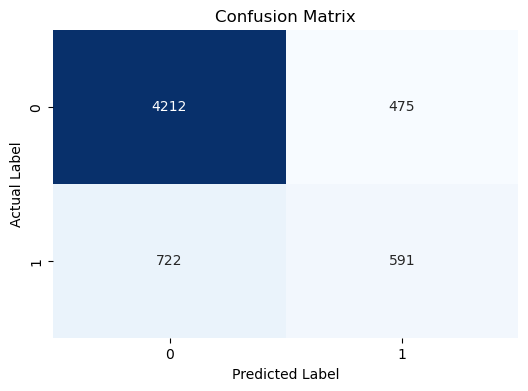

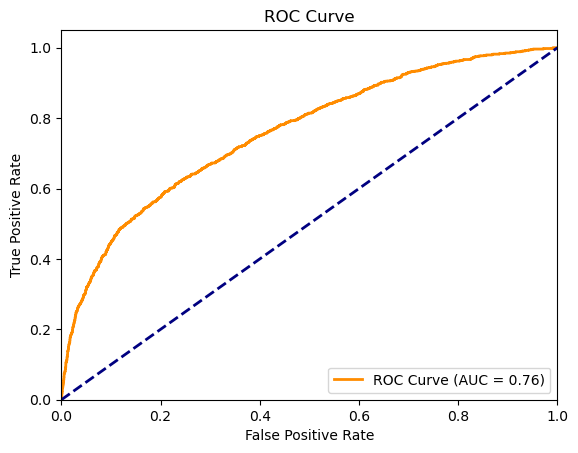

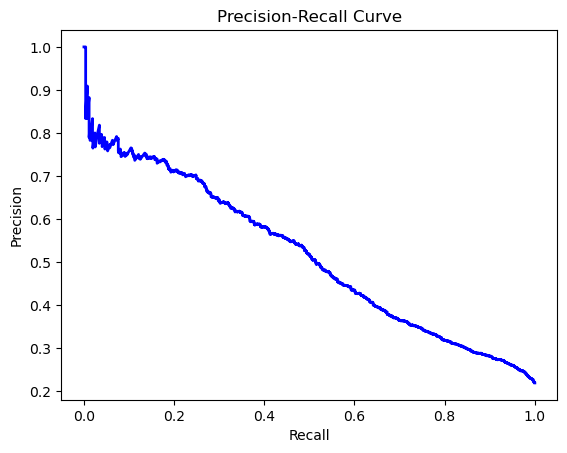

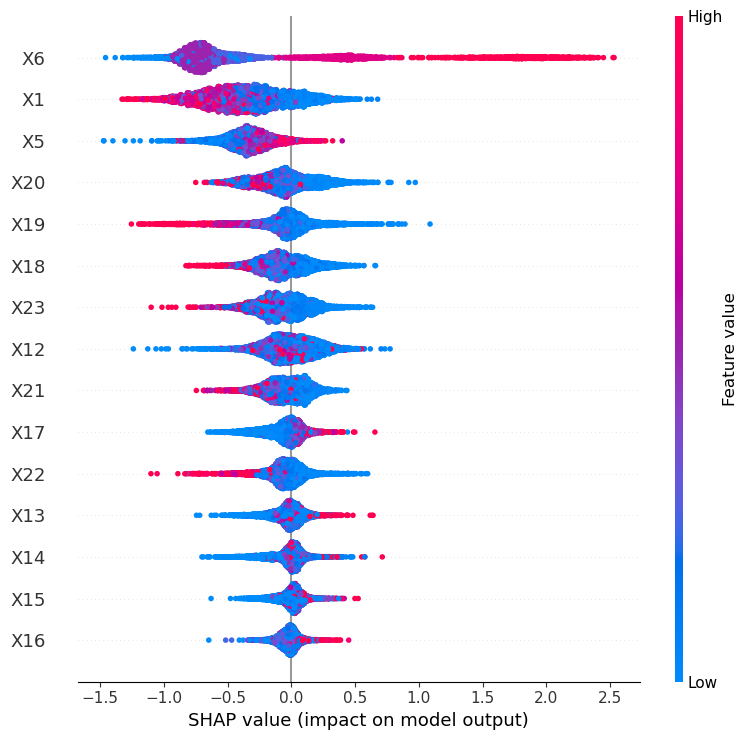

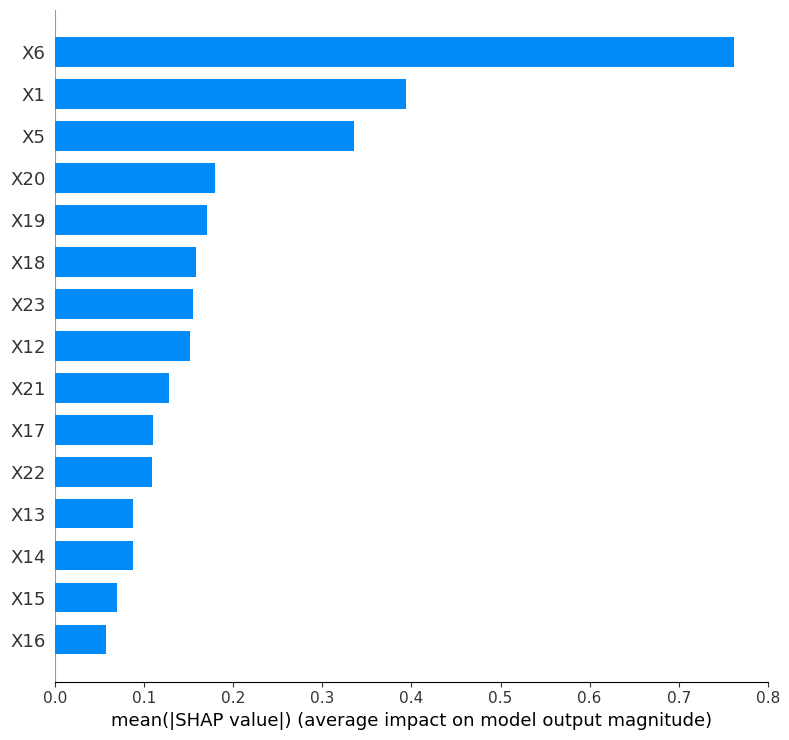

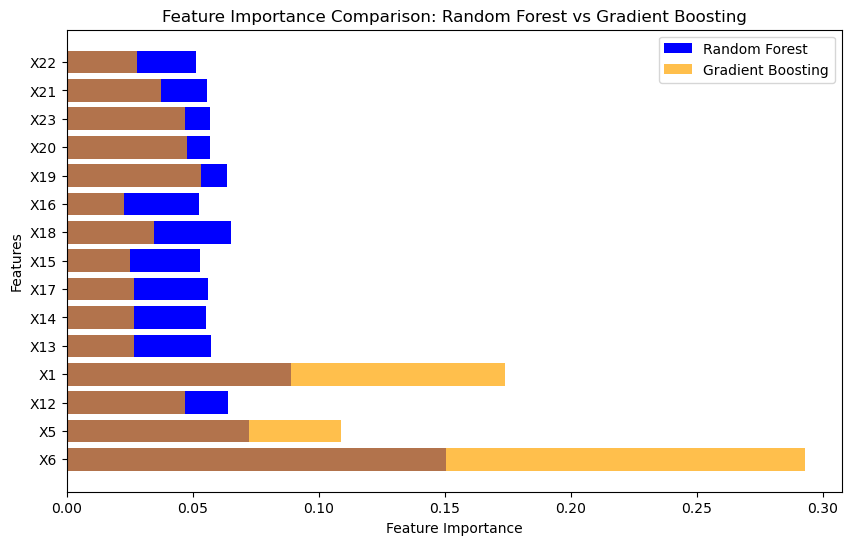

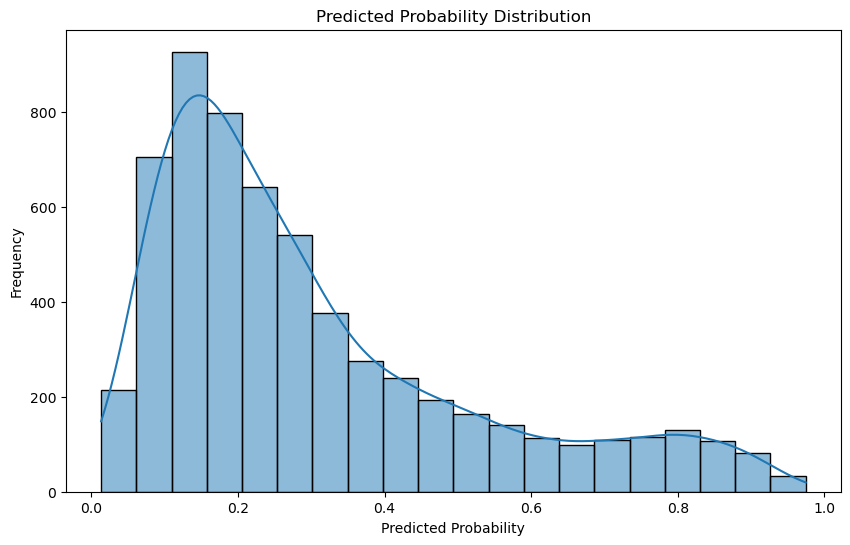

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# SHAP explanation for Gradient Boosting
explainer = shap.TreeExplainer(best_gb_model)
shap_values = explainer.shap_values(X_test_scaled)

# Check if the model is binary or multi-class
if isinstance(shap_values, list):
    # For binary classification, shap_values[1] represents class 1
    shap.summary_plot(shap_values[1], X_test_scaled, feature_names=top_features)
    shap.summary_plot(shap_values[1], X_test_scaled, feature_names=top_features, plot_type="bar")
else:
    # For binary classification with a single output, use shap_values directly
    shap.summary_plot(shap_values, X_test_scaled, feature_names=top_features)
    shap.summary_plot(shap_values, X_test_scaled, feature_names=top_features, plot_type="bar")

# Feature Importance for Random Forest and Gradient Boosting
plt.figure(figsize=(10, 6))
plt.barh(top_features, best_rf_model.feature_importances_, color='b', label='Random Forest')
plt.barh(top_features, best_gb_model.feature_importances_, color='orange', alpha=0.7, label='Gradient Boosting')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Comparison: Random Forest vs Gradient Boosting')
plt.legend()
plt.show()

# Predicted Probability Distribution (to see model confidence)
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba, kde=True, bins=20)
plt.title('Predicted Probability Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()
